In [14]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import warnings
import cProfile

from time import time

from astropy.stats import sigma_clip
from astropy.table import Table, Column, vstack

import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams

from asap import io
from asap import smf 
from asap import config
from asap import fitting
from asap import ensemble
from asap import plotting
from asap.parameters import AsapParams
from asap.likelihood import ln_likelihood, ln_probability
from asap.predictions import (predict_mstar_basic, predict_smf, predict_mhalo,
                              predict_dsigma_profiles, make_model_predictions)

plt.rc('text', usetex=True)

rcParams.update({'axes.linewidth': 1.5})
rcParams.update({'xtick.direction': 'in'})
rcParams.update({'ytick.direction': 'in'})
rcParams.update({'xtick.minor.visible': 'True'})
rcParams.update({'ytick.minor.visible': 'True'})
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '8.0'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '4.0'})
rcParams.update({'xtick.minor.width': '1.5'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '8.0'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '4.0'})
rcParams.update({'ytick.minor.width': '1.5'})
rcParams.update({'axes.titlepad': '10.0'})
rcParams.update({'font.size': 25})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
# From 

def schechter(logm, logphi, logmstar, alpha, m_lower=None):
    """
    Generate a Schechter function (in dlogm).
    """
    phi = ((10**logphi) * np.log(10) *
           10**((logm - logmstar) * (alpha + 1)) *
           np.exp(-10**(logm - logmstar)))
    return phi

def parameter_at_z0(y, z0, z1=0.2, z2=1.6, z3=3.0):
    """
    Compute parameter at redshift ‘z0‘ as a function
    of the polynomial parameters ‘y‘ and the
    redshift anchor points ‘z1‘, ‘z2‘, and ‘z3‘.
    """
    y1, y2, y3 = y
    a = (((y3 - y1) + (y2 - y1) / (z2 - z1) * (z1 - z3)) /
         (z3**2 - z1**2 + (z2**2 - z1**2) / (z2 - z1) * (z1 - z3)))
    b = ((y2 - y1) - a * (z2**2 - z1**2)) / (z2 - z1)
    c = y1 - a * z1**2 - b * z1
    
    return a * z0**2 + b * z0 + c

def get_smf_leja19(z0, ndraw=1000):
    # Continuity model median parameters + 1-sigma uncertainties.
    pars = {'logphi1': [-2.44, -3.08, -4.14],
            'logphi1_err': [0.02, 0.03, 0.1],
            'logphi2': [-2.89, -3.29, -3.51],
            'logphi2_err': [0.04, 0.03, 0.03],
            'logmstar': [10.79,10.88,10.84],
            'logmstar_err': [0.02, 0.02, 0.04],
            'alpha1': [-0.28],
            'alpha1_err': [0.07],
            'alpha2': [-1.48],
            'alpha2_err': [0.1]}

    # Draw samples from posterior assuming independent Gaussian uncertainties.
    # Then convert to mass function at ‘z=z0‘.
    draws = {}

    for par in ['logphi1', 'logphi2', 'logmstar', 'alpha1', 'alpha2']:
        samp = np.array([np.random.normal(median, scale=err, size=ndraw)
                         for median, err in zip(pars[par], pars[par+'_err'])])
        if par in ['logphi1', 'logphi2', 'logmstar']:
            draws[par] = parameter_at_z0(samp, z0)
        else:
            draws[par] = samp.squeeze()

    # Generate Schechter functions.
    logm = np.linspace(8, 12, 100)[:, None]  # log(M) grid

    phi1 = schechter(logm, draws['logphi1'],  # primary component
                     draws['logmstar'], draws['alpha1'])
    phi2 = schechter(logm, draws['logphi2'],  # secondary component
                     draws['logmstar'], draws['alpha2'])
    phi = phi1 + phi2  # combined mass function

    # Compute median and 1-sigma uncertainties as a function of mass.
    phi_50, phi_84, phi_16 = np.percentile(phi, [50, 84, 16], axis=1)
    
    return logm.flatten(), phi_50, phi_84, phi_16

In [34]:
logm, smf_2, smf_2_low, smf_2_upp = get_smf_leja19(0.2)
logm, smf_3, smf_3_low, smf_3_upp = get_smf_leja19(0.3)
logm, smf_4, smf_4_low, smf_4_upp = get_smf_leja19(0.4)
logm, smf_5, smf_5_low, smf_5_upp = get_smf_leja19(0.5)
logm, smf_10, smf_10_low, smf_10_upp = get_smf_leja19(1.0)

In [8]:
test_dir = '../model/'
model_str = 'final_6'

# The configuration file
config_file = os.path.join(test_dir, 'asap_test_%s.yaml' % model_str)

# The results from the 3-stage burn-in results
burnin_file_1 = os.path.join(test_dir, 'asap_test_%s_burnin_1.npz' % model_str)
burnin_file_2 = os.path.join(test_dir, 'asap_test_%s_burnin_2.npz' % model_str)
#burnin_file_3 = os.path.join(test_dir, 'asap_test_%s_burnin_3.npz' % model_str)

# The results of the final sampling process
result_file = os.path.join(test_dir, 'asap_test_%s_sample.npz' % model_str)

# Initialize the model, load the data
cfg, params, obs_data, um_data = fitting.initial_model(config_file, verbose=True)

# Running model: asap_test_final_6
#    Will use emcee as sampler ...
#    Use   256 walkers with    snooker moves for   200 x  3 steps of burn-in
#    Use   256 walkers with        kde moves for 15000 steps of sampling

# Observations:
# Galaxy catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# DSigma results: s16a_wide2_dsigma_logm11.6_12_bins.npy
# SMF of inner Mstar: s16a_wide2_massive_smf_m10_11.6.npy
# SMF of total Mstar: s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: s16a_wide2_massive_smf_mmax_m10_cov.npy
# Reference SMF: primus_smf_z0.3_0.4.fits
# Column of inner Mstar: logm_10
# Column of total Mstar: logm_max

# UniverseMachine:
# Galaxy catalog : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_short.npy
# DSigma results : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_50m_r_0.08_50_22bins.npy
# Volumn of the simulation:    205348196.23 Mpc^3
# Halo mass : logmh_host
# Stellar mass : logms_tot
# There are 12 DSigma profiles in this sample
# SMF for total 

In [7]:
obs_data['smf_tot']

array([(11.65, 11.6, 11.7, 1.71161607e-04, 1.20814277e-05, 1.59080179e-04, 1.83243035e-04),
       (11.75, 11.7, 11.8, 8.47523361e-05, 7.80613369e-06, 7.69462024e-05, 9.25584698e-05),
       (11.85, 11.8, 11.9, 3.54304684e-05, 4.30153739e-06, 3.11289310e-05, 3.97320058e-05),
       (11.95, 11.9, 12. , 1.29720695e-05, 2.80263948e-06, 1.01694301e-05, 1.57747090e-05),
       (12.05, 12. , 12.1, 3.14448583e-06, 1.26828718e-06, 1.87619864e-06, 4.41277301e-06),
       (12.15, 12.1, 12.2, 8.79523394e-07, 6.43642169e-07, 2.35881225e-07, 1.52316556e-06),
       (12.25, 12.2, 12.3, 1.82666668e-07, 2.87105622e-07, 1.00000000e-08, 4.69772289e-07)],
      dtype=[('logm_mean', '<f8'), ('logm_0', '<f8'), ('logm_1', '<f8'), ('smf', '<f8'), ('smf_err', '<f8'), ('smf_low', '<f8'), ('smf_upp', '<f8')])

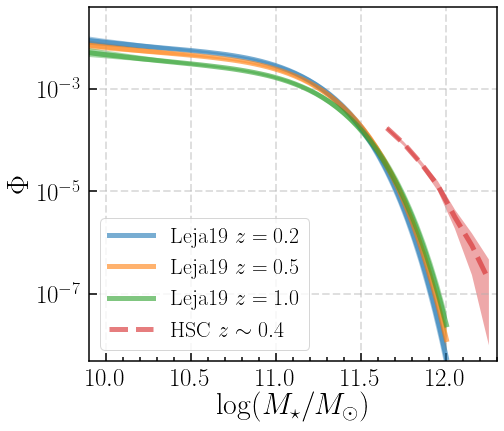

In [36]:
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(left=0.18, right=0.99,
                    bottom=0.13, top=0.95,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

ax1.set_yscale("log", nonposy='clip')

ax1.fill_between(logm, smf_2_low, smf_2_upp, alpha=0.4)
ax1.plot(logm, smf_2, linestyle='-', linewidth=5.0, alpha=0.6, 
         label=r'${\rm Leja19}\ z=0.2$')

ax1.fill_between(logm, smf_5_low, smf_5_upp, alpha=0.4)
ax1.plot(logm, smf_5, linestyle='-', linewidth=5.0, alpha=0.6, 
         label=r'${\rm Leja19}\ z=0.5$')

ax1.fill_between(logm, smf_10_low, smf_10_upp, alpha=0.4)
ax1.plot(logm, smf_10, linestyle='-', linewidth=5.0, alpha=0.6, 
         label=r'${\rm Leja19}\ z=1.0$')

ax1.fill_between(obs_data['smf_tot']['logm_mean'], 
                 obs_data['smf_tot']['smf_low'],
                 obs_data['smf_tot']['smf_upp'], alpha=0.4)
ax1.plot(obs_data['smf_tot']['logm_mean'], obs_data['smf_tot']['smf'], 
         linestyle='--', linewidth=5.0, alpha=0.6, 
         label=r'${\rm HSC}\ z\sim 0.4$')

ax1.legend(loc='best', fontsize=22)

_ = ax1.set_xlim(9.9, 12.3)
_ = ax1.set_ylim(0.5e-8, 4e-2)

_ = ax1.set_xlabel(r'$\log (M_{\star}/M_{\odot})$', fontsize=30)
_ = ax1.set_ylabel(r'$\Phi$', fontsize=30)